In [ ]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
import time
warnings.filterwarnings('ignore')
np.random.seed(4950)

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_hist_trans = pd.read_csv('../../ELO/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../../ELO/new_merchant_transactions.csv')

In [ ]:
df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_merchant_trans = reduce_mem_usage(df_new_merchant_trans)

In [6]:
df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [8]:
df_train['first_active_month']=pd.to_datetime(df_train['first_active_month']).dt.date

In [11]:
df_hist_trans['purchase_date']=pd.to_datetime(df_hist_trans['purchase_date']).dt.date

In [13]:
df_first_purchase=df_hist_trans.groupby('card_id').purchase_date.min()

In [14]:
df_train['first_purchase']=df_train.card_id.map(df_first_purchase)

In [18]:
df_early=df_train[df_train['first_purchase']<df_train['first_active_month']]

In [24]:
df_early[df_early['target']<-33].shape[0]/df_early.shape[0]

0.004973291582243507

In [27]:
df_train[df_train.target<-33].shape[0]/df_train.shape[0]

0.010930233709890698

In [30]:
df_early['date_diff']=df_early['first_active_month']-df_early['first_purchase']

In [39]:
df_early['date_diff'].

numpy.timedelta64(3715200000000000,'ns')

In [64]:
df_early['date_diff'].head()

59    43 days
97    37 days
133   22 days
244   16 days
290    4 days
Name: date_diff, dtype: timedelta64[ns]

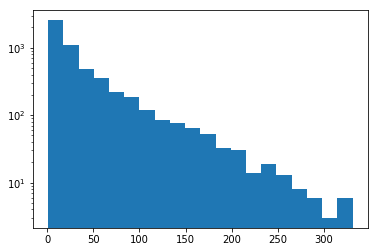

In [66]:
plt.figure()
plt.hist((df_early['date_diff'].values/(24*60*60*1e9)).astype('float'),bins=20)
plt.yscale('log')

Text(0.5,0,'day_diff')

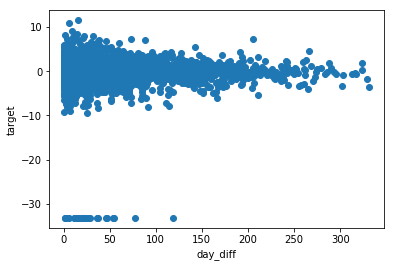

In [68]:
plt.figure()
plt.scatter((df_early['date_diff'].values/(24*60*60*1e9)).astype('float'),df_early.target)
plt.ylabel('target')
plt.xlabel('day_diff')

In [82]:
df_early[df_early.date_diff>pd.to_timedelta('120 days')].shape

(377, 8)

In [29]:
df_early[df_early.card_id=='C_ID_02e9714314']

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_purchase
2391,2017-12-01,C_ID_02e9714314,5,2,1,-0.537867,2017-01-18


In [45]:
df_test['first_active_month']=pd.to_datetime(df_test['first_active_month']).dt.date

In [46]:
df_test['first_purchase']=df_test.card_id.map(df_first_purchase)

In [49]:
df_early_test=df_test[df_test['first_purchase']<df_test['first_active_month']]

In [76]:
df_early_test['date_diff']=df_early_test['first_active_month']-df_early_test['first_purchase']

In [77]:
df_early_test[df_early_test.date_diff>pd.to_timedelta('120 days')].shape

(196, 7)

In [80]:
df_early_test[df_early_test.date_diff>pd.to_timedelta('120 days')].to_csv('day_diff_more_120.csv',index=False)

In [83]:
df_early_test[df_early_test.date_diff>pd.to_timedelta('60 days')].to_csv('day_diff_more_60.csv',index=False)

In [85]:
df_early_test.to_csv('day_diff_more_all.csv',index=False)

In [92]:
#df_early_test['date_diff']=df_early_test.date_diff.dt.days
df_early_test.to_csv('day_diff_more_all.csv',index=False)

In [ ]:
df_hist